# 손글씨 이미지 추측 모델 개발 (MNIST Dataset 활용)

In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST    # MNIST 손글씨 데이터넷 로드

from torchvision.transforms import ToTensor # 이미지를 PyTorch Tensor로 변환
from torch.utils.data.dataloader import DataLoader  # 데이터셋을 batch 단위로 불러오고, 셔플/멀티스레드 로딩 지원

import torch
import torch.nn as nn   # 모델, 연산, 신경망 계층 정의  
from torch.optim.adam import Adam # 최적화 알고리즘
from tensorboardX import SummaryWriter

## 1. 데이터 불러오기

MNIST 에서 제공하는 데이터셋을 불러온다
- 실전에서는 아래 MNIST 함수를 사용할 일이 거의 없을 것이다
- 그러니, train_data 와 test_data 로 데이터를 나눈다는 사실만 기억하자

In [3]:
train_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=False, download=True, transform=ToTensor())

## 2. 데이터 확인하기

데이터를 가져오면 무조건 사이즈를 확인해보자

In [4]:
train_data.data.size()
# 이 데이터는 60000장의 이미지 데이터들이 있고, 각 데이터는 28 x 28 이미지
# (28 x 28 = 784 픽셀의 이미지)

torch.Size([60000, 28, 28])

In [ ]:
# 각 이미지에 적힌 숫자에 대한 정답 데이터
train_data.targets

In [ ]:
# 학습 데이터 중 이미지 한장을 확인해보자
train_data.data[0]

In [ ]:
# 이미지를 시각화 해보자
# cmap='gray' 옵션을 넣어서 이미지를 흑백으로 그려보자
plt.imshow(train_data.data[0], cmap='gray')
plt.show()

## 3. 배치 사이즈에 따른 데이터 분리

In [5]:
# 60000개의 데이터를 32개씩 쪼개면 1875개로 나뉘어 진다
60000/32

1875.0

In [ ]:
# DataLoader 를 사용하여 데이터를 나눈다
# ⭐ batch_size 몇 개씩 그룹 지을지 정한다
# ⭐ shuffle 데이터를 순서대로 나누는 것이 아니라 랜덤으로 섞어서 자른다 
# 학습에 영향을 줄 수 있으므로 Train Data 에는 True 로 설정 하자!
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True) # test data 에는 shuffle 을 꼭 할 필요 없다

In [ ]:
train_loader.dataset

In [ ]:
# train_loader 에서 첫번째 데이터 묶음 (32개 묶음) 을 확인해보자
data = next(iter(train_loader))[0]
data.shape 
# [ 32, 1, 28, 28 ]
# 32개의 이미지 데이터, 3차원 이미지 데이터 [ 채널수, 이미지 가로 픽셀, 이미지 세로 픽셀 ]
# 채널수는 RGB 컬러 이미지일 경우 3, 흑백 이미지일 경우 1 등 이미지의 형식에 따라 다를 수 있다!

In [ ]:
next(iter(train_loader))[1]

## 4. 모델 만들기

In [ ]:
# 모델 정의
# nn.Sequential: 레이어를 순서대대로 쌓는 컨테이너
# nn.Linear: 완전 연결 계층
# nn.ReLU: 활성화함수

# ⭐ Linear 즉 선형함수 다음에는 활성화 함수를 반드시 거치자
# 샌드위치처럼 Linear 이 빵이고, 활성함수는 고기다

# ⭐⭐ 모델의 인풋값인 784, 아웃풋값이 10 에 대해서 반드시 이해할 것
# 이 모델은 이미지 한장을 인풋으로 넣고, 그 이미지가 0-9 중 어떤 숫자가 쓰여져 있는지 예측 합니다
# 인풋 값 : 28 x 28 인 2차원이 이미지를 1차원으로 펼치면 784 개의 요소를 가진 1차원 리스트가 될 것이다.
# 아웃풋 값 : 이 모델의 결과, 이 이미지가 각각 0 - 9 중 어떤 숫자 일 확률이 더 높은지, 각 숫자별로 해당 숫자일 확률에 대한 데이터를 계산해준다

# ⭐ 중요한 것이 각 레이어 마다 64로 끝났으면 다음 레이어에서는 64로 시작해야한다는 점이다
# 즉 이전 레이어의 출력과 다음 레이어의 입력의 값이 동일할 것!
model = nn.Sequential(
    nn.Linear(in_features=784, out_features=64), # ✅ 선형 함수 > 인풋 레이어
    nn.ReLU(),                                   # ✅ 활성화 함수
    nn.Linear(in_features=64, out_features=64),  # ✅ 선형 함수
    nn.ReLU(),                                   # ✅ 활성화 함수
    nn.Linear(in_features=64, out_features=10),  # ✅ 선형 함수
)
# ⭐ 여기서 만든 모델은 아직 실행하지 읺았다!!
# 실제로 실행은 다음 모델 학습의 순전파 단계에서 이루어 진다!!

## 5. 모델 학습

In [ ]:
# 내 컴퓨터에서 cuda가 있다면? 'cuda' 없으면 'cpu' 를 저장
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 GPU 에 올리기
model.to(device)

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

lr = 1e-3                               # ✅ 러닝레이트: 일반적으로 0.001 ~ 0.003
criterion = nn.CrossEntropyLoss()       # ✅ 손실 함수 : 분류모델 - nn.CrossEntropyLoss() / 다른 모델 - nn.MSELoss()
optim = Adam(model.parameters(), lr=lr) # 파라미터 업데이트 최적화 알고리즘
epochs  = 20                            # ✅ 학습 반복 횟수

# tensorboard로 손실값의 변화를 그래프로 확인 가능
step = 0

for epoch in range(epochs):
    # data : 32개의 이미지 데이터 / label : 32개의 이미지의 정답 데이터
    for data, label in train_loader: # [(data, label)]
        optim.zero_grad() # 📌 최적화 함수를 초기화 해야함 (한 번 학습시 마다)

        # ⭐⭐ 모델의 입력 데이터 형식에 반드시 맞출 것
        data = torch.reshape(data, (-1, 784)) 

        # 1) 순전파
        pred = model(data.to(device))

        # 2) 손실 계산
        loss = criterion(pred, label.to(device)) # 데이터 위치 체크

        # 3) 역전파
        loss.backward()
        optim.step() # 4) 파라미터 업데이트

        # tensorboard에 데이터 추가
        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1

    print(f"{epoch} loss : {loss.item()}")

## 학습 결과 시각적으로 확인하기

`uv add tensorboardX`

`uv add tensorboard`
`uv run tensorboard --logdir=runs`
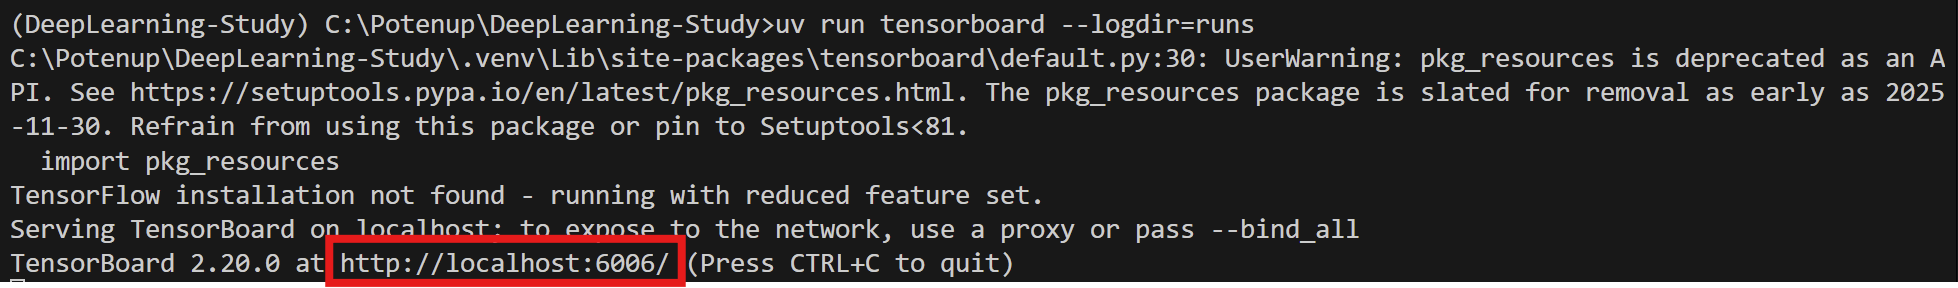

## 6. 모델 저장하기

In [ ]:
# 📌 ⭐⭐⭐ 학습시킨 모델이 날라가지 않도록 반드시 꼭꼭 저장하자
import joblib

# 모델 저장
joblib.dump(model, 'models/number_image_classification_model.pkl')

## 7. 모델 평가 :  이미지 맞춰보기 (추론용 모델 만들기)

In [ ]:
test_loader.dataset

In [ ]:
# 모델 불러오기
import joblib

model = joblib.load('models/number_image_classification_model.pkl')

In [ ]:
model.eval() # 📌 모델을 추론용으로 전환하게 하는 코드

# 추가 작성 코드
# falut_data = []

# 📌 모델 역전파(파라미터 업데이트)를 하지 않고 순전파 계산만 하게 한다
with torch.no_grad():
    total_corr = 0
    for images, labels in test_loader:

        X = images.view(-1, 784).to(device)
        labels = labels.to(device)

        preds = model(X)
        _, pred = torch.max(preds.data, dim = 1)
        
        result = (pred == labels)
        total_corr += (result).sum().item()

        # 추가 작성 코드
        # for i, re in enumerate(result):
        #     if re == False:
        #         falut_data.append({
        #             'image' : images[i],
        #             'pred' : pred[i],
        #             'label' :labels[i]
        #         })

print(f'정확도 : {total_corr / len(test_data.targets)}')

In [ ]:
# for falut in falut_data:
#     print(f"예측 : {falut['pred']}, 정답 : {falut['label']}")
#     plt.imshow(falut['image'].view(28, 28), cmap='gray')
#     plt.show()

In [ ]:
preds.data.shape

In [ ]:
_, pred = torch.max(preds.data, dim = 1)
pred

In [ ]:
pred == labels

In [ ]:
(pred == labels).sum()